In [ ]:
# First time users of Wordcloud and contractions need to pip install
import sys  
!{sys.executable} -m pip install wordcloud

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import *
import nltk
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import f1_score, accuracy_score


In [290]:
# If previously not downloaded, run this
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamespark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jamespark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Import necessary data (total training data will be data so as to not confuse when splitting)
data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

# We only want the data (X) and class label (y)
data = data[["text","sentiment"]]
data

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn't become the 5th...,neutral
3,"""prince george reservist who died saturday ju...",neutral
4,season in the sun versi nirvana rancak gak..s...,positive
...,...,...
21797,@hrtablaze the beginning of a dictatorship is ...,negative
21798,son idc anymore. i'm going by shawn tomorrow,neutral
21799,but remember the clinton foundation?? https://...,neutral
21800,"press: ""r u worried murray dominated his 3rd r...",neutral


In [3]:
#separating instance and label for Train
X_train_raw = [x[0] for x in data[['text']].values]
Y_train = [x[0] for x in data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [4]:
#Let's see one example tweet
print(X_train_raw[132])

 remember how zayn left the band on my 18th birthday :/ #5monthswithoutzayn	


## FUNCTIONS USED 


In [5]:
def split_by_class(data):
    data_pos = data.loc[data['sentiment'] == 'positive']
    data_neg = data.loc[data['sentiment'] == 'negative']
    data_neu = data.loc[data['sentiment'] == 'neutral']
    
    return data_pos, data_neg, data_neu

In [6]:
def get_occurence(pattern, data):
    all_occurence = {}
    for sentence in data:
        values = re.findall(pattern, sentence)
        for val in values:
            if val in all_occurence:
                all_occurence[val]+=1
            else:
                all_occurence[val] = 1
    return Counter(list(all_occurence.values()))

# Feature Engineering

In [7]:
X_train_pre = X_train_raw.copy()

# (1) Lowercase
X_train_pre = [sentence.lower() for sentence in X_train_pre]
X_train_pre

[' doctors hit campaign trail as race to medical council elections heats up https://t.co/iifdwb9v0w #homeopathy',
 ' is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:\t',
 " i just found out naruto didn't become the 5th hokage....\t",
 ' "prince george reservist who died saturday just wanted to help people, his father tells @cbcnews http://t.co/riauzrjgre"\t',
 ' season in the sun versi nirvana rancak gak..slow rockkk...\t',
 " if i didnt have you i'd never see the sun. #mtvstars lady gaga\t",
 ' this is cute. #thisisus @nbcthisisus https://t.co/ndxqyl4gjk',
 ' today is the international day for the elimination of violence against women #orangetheworld #unitednations #unodc‚ä¶ https://t.co/uyqctttufj',
 ' "in his first game back since april 14, david wright went 2-for-5 with a hr, bb and three r on monday. he also made two errors at 3b."\t',
 ' josh hamilton flies out to center... we are going to the

In [8]:
# Check if URLs have any meaning
url_pattern = r'https?://([^\s]+)'
urls = get_occurence(url_pattern, X_train_pre)

# Now that we collated all the URLs in all the documents, we see if there are any URLs that are repeating.
# If there are, we would then split the dataset according to class label and retrieve the URLs again to see if 
# there are any reoccuring URLs for that specific class label.
print(urls.keys())
print(urls.values())

dict_keys([1, 2, 6, 3, 4])
dict_values([9203, 27, 1, 2, 1])


In [9]:
# (2) Remove URLs
X_train_pre2 = [re.sub(url_pattern, ' ', sentence) for sentence in X_train_pre]
X_train_pre2

[' doctors hit campaign trail as race to medical council elections heats up   #homeopathy',
 ' is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:\t',
 " i just found out naruto didn't become the 5th hokage....\t",
 ' "prince george reservist who died saturday just wanted to help people, his father tells @cbcnews  \t',
 ' season in the sun versi nirvana rancak gak..slow rockkk...\t',
 " if i didnt have you i'd never see the sun. #mtvstars lady gaga\t",
 ' this is cute. #thisisus @nbcthisisus  ',
 ' today is the international day for the elimination of violence against women #orangetheworld #unitednations #unodc‚ä¶  ',
 ' "in his first game back since april 14, david wright went 2-for-5 with a hr, bb and three r on monday. he also made two errors at 3b."\t',
 ' josh hamilton flies out to center... we are going to the bottom of the 9th tied at 7! #nevereverquit\t',
 ' watch the trump protest that shut do

In [10]:
# Now we test to see if tags could be removed or not
tag_pattern = r'@(\w+)+'
tags = get_occurence(tag_pattern, X_train_pre2)

print(tags.keys())
print(tags.values())

dict_keys([2, 144, 1, 161, 4, 20, 3, 35, 5, 17, 8, 65, 14, 29, 37, 43, 15, 9, 7, 6, 12, 34, 22, 26, 64, 24, 11, 10, 23, 31, 18, 13])
dict_values([496, 1, 6472, 1, 79, 2, 155, 1, 38, 3, 14, 2, 3, 1, 2, 1, 2, 7, 19, 22, 8, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1])


In [11]:
# Now we test to see if hashtags could be removed or not
hash_pattern = r'#(\w+)'
hashes = get_occurence(hash_pattern, X_train_pre2)

print(hashes.keys())
print(hashes.values())

dict_keys([16, 66, 61, 5, 58, 1, 22, 13, 42, 53, 4, 10, 3, 26, 23, 45, 8, 9, 54, 36, 98, 51, 14, 12, 72, 2, 34, 68, 57, 69, 6, 17, 60, 33, 38, 67, 62, 7, 79, 27, 19, 76, 43, 11, 50, 25, 59, 87, 20, 55, 41, 32, 64, 39, 28, 48, 31, 15])
dict_values([8, 4, 4, 52, 1, 3572, 3, 8, 1, 1, 116, 11, 170, 2, 3, 1, 20, 14, 2, 4, 2, 2, 3, 8, 2, 454, 1, 2, 3, 1, 37, 6, 3, 1, 1, 1, 1, 26, 1, 2, 1, 1, 2, 13, 1, 2, 2, 1, 4, 2, 1, 1, 1, 2, 1, 1, 1, 4])


In [12]:
# We see that both tags and hashtags could have an impact. So we will split the data according to their sentiment value and see if tha tags are relevant to specific class
data_pos, data_neg, data_neu = split_by_class(pd.DataFrame({'text': X_train_pre2, 'sentiment': Y_train}))
pos_tag = get_occurence(tag_pattern, data_pos['text'])
neg_tag = get_occurence(tag_pattern, data_neg['text'])
neu_tag = get_occurence(tag_pattern, data_neu['text'])

pos_hash = get_occurence(hash_pattern, data_pos['text'])
neg_hash = get_occurence(hash_pattern, data_neg['text'])
neu_hash = get_occurence(hash_pattern, data_neu['text'])

# Get top 5 highest occurences and number of tags/hashes contained
print("Positive sentiment tags: ")
print(" - occurences for tags:           ", sorted(list(pos_tag.keys()), reverse = True)[:5])
print(" - # of tags with that occurency: ", [pos_tag[key] for key in sorted(list(pos_tag.keys()), reverse = True)[:5]])
print(" - occurences for hashtags:           ", sorted(list(pos_hash.keys()), reverse = True)[:5])
print(" - # of hashtags with that occurency: ", [pos_hash[key] for key in sorted(list(pos_hash.keys()), reverse = True)[:5]])

print("Negative sentiment tags: ")
print(" - occurences for tags:           ", sorted(list(neg_tag.keys()), reverse = True)[:5])
print(" - # of tags with that occurency: ", [neg_tag[key] for key in sorted(list(neg_tag.keys()), reverse = True)[:5]])
print(" - occurences for hashtags:           ", sorted(list(neg_hash.keys()), reverse = True)[:5])
print(" - # of hashtags with that occurency: ", [neg_hash[key] for key in sorted(list(neg_hash.keys()), reverse = True)[:5]])

print("Neutral sentiment tags: ")
print(" - occurences for tags:           ", sorted(list(neu_tag.keys()), reverse = True)[:5])
print(" - # of tags with that occurency: ", [neu_tag[key] for key in sorted(list(neu_tag.keys()), reverse = True)[:5]])
print(" - occurences for hashtags:           ", sorted(list(neu_hash.keys()), reverse = True)[:5])
print(" - # of hashtags with that occurency: ", [neu_hash[key] for key in sorted(list(neu_hash.keys()), reverse = True)[:5]])

Positive sentiment tags: 
 - occurences for tags:            [65, 32, 20, 12, 11]
 - # of tags with that occurency:  [1, 1, 1, 2, 1]
 - occurences for hashtags:            [43, 40, 33, 30, 29]
 - # of hashtags with that occurency:  [1, 1, 2, 2, 1]
Negative sentiment tags: 
 - occurences for tags:            [62, 20, 18, 15, 13]
 - # of tags with that occurency:  [1, 1, 3, 1, 1]
 - occurences for hashtags:            [29, 26, 23, 21, 19]
 - # of hashtags with that occurency:  [1, 1, 2, 1, 2]
Neutral sentiment tags: 
 - occurences for tags:            [79, 70, 39, 34, 31]
 - # of tags with that occurency:  [1, 1, 1, 1, 1]
 - occurences for hashtags:            [79, 74, 58, 55, 52]
 - # of hashtags with that occurency:  [1, 1, 1, 1, 1]


In [13]:
# (3) Remove tags
X_train_pre3 = [re.sub(tag_pattern, '', sentence) for sentence in X_train_pre2]

# (4) Remove hashtags
X_train_pre4 = [re.sub(hash_pattern, '', sentence) for sentence in X_train_pre3]

In [15]:
# (5) Remove punctuations
pattern1 = r'[^\w\s]'
X_train_pre5 = [re.sub(pattern1, ' ', sentence) for sentence in X_train_pre4]
X_train_pre5

[' doctors hit campaign trail as race to medical council elections heats up   ',
 ' is anybody going to the radio station tomorrow to see shawn  me and my friend may go but we would like to make new friends meet there   \t',
 ' i just found out naruto didn t become the 5th hokage    \t',
 '  prince george reservist who died saturday just wanted to help people  his father tells   \t',
 ' season in the sun versi nirvana rancak gak  slow rockkk   \t',
 ' if i didnt have you i d never see the sun   lady gaga\t',
 ' this is cute     ',
 ' today is the international day for the elimination of violence against women    ä   ',
 '  in his first game back since april 14  david wright went 2 for 5 with a hr  bb and three r on monday  he also made two errors at 3b  \t',
 ' josh hamilton flies out to center    we are going to the bottom of the 9th tied at 7  \t',
 ' watch the trump protest that shut down parts of new york city   via ',
 ' wanna see basse try out some dark souls    see the vid below

In [16]:
# (6) Remove stopwords
X_train_pre6 = []
stopwords = list(text.ENGLISH_STOP_WORDS)
# From visualisation from wordcloud, we add more stopwords we think are necessary
stopwords.extend(['tomorrow', 'day', 'time'])

for sentence in X_train_pre5:
    tokens = [w for w in sentence.split() if w not in stopwords]
    X_train_pre6.append(" ".join(tokens))
X_train_pre6


['doctors hit campaign trail race medical council elections heats',
 'anybody going radio station shawn friend like make new friends meet',
 'just naruto didn t 5th hokage',
 'prince george reservist died saturday just wanted help people father tells',
 'season sun versi nirvana rancak gak slow rockkk',
 'didnt d sun lady gaga',
 'cute',
 'today international elimination violence women ä',
 'game april 14 david wright went 2 5 hr bb r monday errors 3b',
 'josh hamilton flies center going 9th tied 7',
 'watch trump protest shut parts new york city',
 'wanna basse try dark souls vid dark souls ii giant 1st boss',
 '8 hour shift consist thinking ed sheeran',
 'seriously debating going paper towns',
 'pay backs senior citizens medicare services shame',
 'stop posting picture s january charlie hebdo attacks tonight',
 'david price toronto blue jays offense',
 'buying scuba suit underwater scenes sharknado',
 'kanye west carried speech',
 'exporting british values 1918 liberty democracy look

In [17]:
# (7) 1 space inbetween words
pattern2 = r'\s+'
X_train_pre7 = [re.sub(pattern2, ' ', sentence) for sentence in X_train_pre6]
X_train_pre7

['doctors hit campaign trail race medical council elections heats',
 'anybody going radio station shawn friend like make new friends meet',
 'just naruto didn t 5th hokage',
 'prince george reservist died saturday just wanted help people father tells',
 'season sun versi nirvana rancak gak slow rockkk',
 'didnt d sun lady gaga',
 'cute',
 'today international elimination violence women ä',
 'game april 14 david wright went 2 5 hr bb r monday errors 3b',
 'josh hamilton flies center going 9th tied 7',
 'watch trump protest shut parts new york city',
 'wanna basse try dark souls vid dark souls ii giant 1st boss',
 '8 hour shift consist thinking ed sheeran',
 'seriously debating going paper towns',
 'pay backs senior citizens medicare services shame',
 'stop posting picture s january charlie hebdo attacks tonight',
 'david price toronto blue jays offense',
 'buying scuba suit underwater scenes sharknado',
 'kanye west carried speech',
 'exporting british values 1918 liberty democracy look

In [18]:
# (8) Remove all numeric numbers
pattern3 = r'[0-9]+'
X_train_pre8 = [re.sub(pattern3, '', sentence) for sentence in X_train_pre7]
X_train_pre8

['doctors hit campaign trail race medical council elections heats',
 'anybody going radio station shawn friend like make new friends meet',
 'just naruto didn t th hokage',
 'prince george reservist died saturday just wanted help people father tells',
 'season sun versi nirvana rancak gak slow rockkk',
 'didnt d sun lady gaga',
 'cute',
 'today international elimination violence women ä',
 'game april  david wright went   hr bb r monday errors b',
 'josh hamilton flies center going th tied ',
 'watch trump protest shut parts new york city',
 'wanna basse try dark souls vid dark souls ii giant st boss',
 ' hour shift consist thinking ed sheeran',
 'seriously debating going paper towns',
 'pay backs senior citizens medicare services shame',
 'stop posting picture s january charlie hebdo attacks tonight',
 'david price toronto blue jays offense',
 'buying scuba suit underwater scenes sharknado',
 'kanye west carried speech',
 'exporting british values  liberty democracy look like',
 'good

In [19]:
# porter stemmer --> looking = look

# (8) Tokenize texts and Stemming (Porter) 
X_train_pre_tokenized = [nltk.word_tokenize(sentence) for sentence in X_train_pre8]
porter = PorterStemmer()
X_train_pre_stem = [[porter.stem(word) for word in words] for words in X_train_pre_tokenized]
X_train_pre_stem

[['doctor',
  'hit',
  'campaign',
  'trail',
  'race',
  'medic',
  'council',
  'elect',
  'heat'],
 ['anybodi',
  'go',
  'radio',
  'station',
  'shawn',
  'friend',
  'like',
  'make',
  'new',
  'friend',
  'meet'],
 ['just', 'naruto', 'didn', 't', 'th', 'hokag'],
 ['princ',
  'georg',
  'reservist',
  'die',
  'saturday',
  'just',
  'want',
  'help',
  'peopl',
  'father',
  'tell'],
 ['season', 'sun', 'versi', 'nirvana', 'rancak', 'gak', 'slow', 'rockkk'],
 ['didnt', 'd', 'sun', 'ladi', 'gaga'],
 ['cute'],
 ['today', 'intern', 'elimin', 'violenc', 'women', 'ä'],
 ['game',
  'april',
  'david',
  'wright',
  'went',
  'hr',
  'bb',
  'r',
  'monday',
  'error',
  'b'],
 ['josh', 'hamilton', 'fli', 'center', 'go', 'th', 'tie'],
 ['watch', 'trump', 'protest', 'shut', 'part', 'new', 'york', 'citi'],
 ['wan',
  'na',
  'bass',
  'tri',
  'dark',
  'soul',
  'vid',
  'dark',
  'soul',
  'ii',
  'giant',
  'st',
  'boss'],
 ['hour', 'shift', 'consist', 'think', 'ed', 'sheeran'],
 ['s

In [20]:
# (9) Remove any words that have < 2 in length as they do not make much sense to add meaning
X_train_pre_trunc = [[word for word in words if len(word)>2] for words in X_train_pre_stem]

In [21]:
# Get count frequency of words in each sentiment to visualise data
data_pos, data_neg, data_neu = split_by_class(pd.DataFrame({'text': X_train_pre_trunc, 'sentiment': Y_train}))
print("Number of texts for positive sentiment: ", len(data_pos))
print("Number of texts for negative sentiment: ", len(data_neg))
print("Number of texts for neutral sentiment: ", len(data_neu))

Number of texts for positive sentiment:  5428
Number of texts for negative sentiment:  3715
Number of texts for neutral sentiment:  12659


(-0.5, 399.5, 199.5, -0.5)

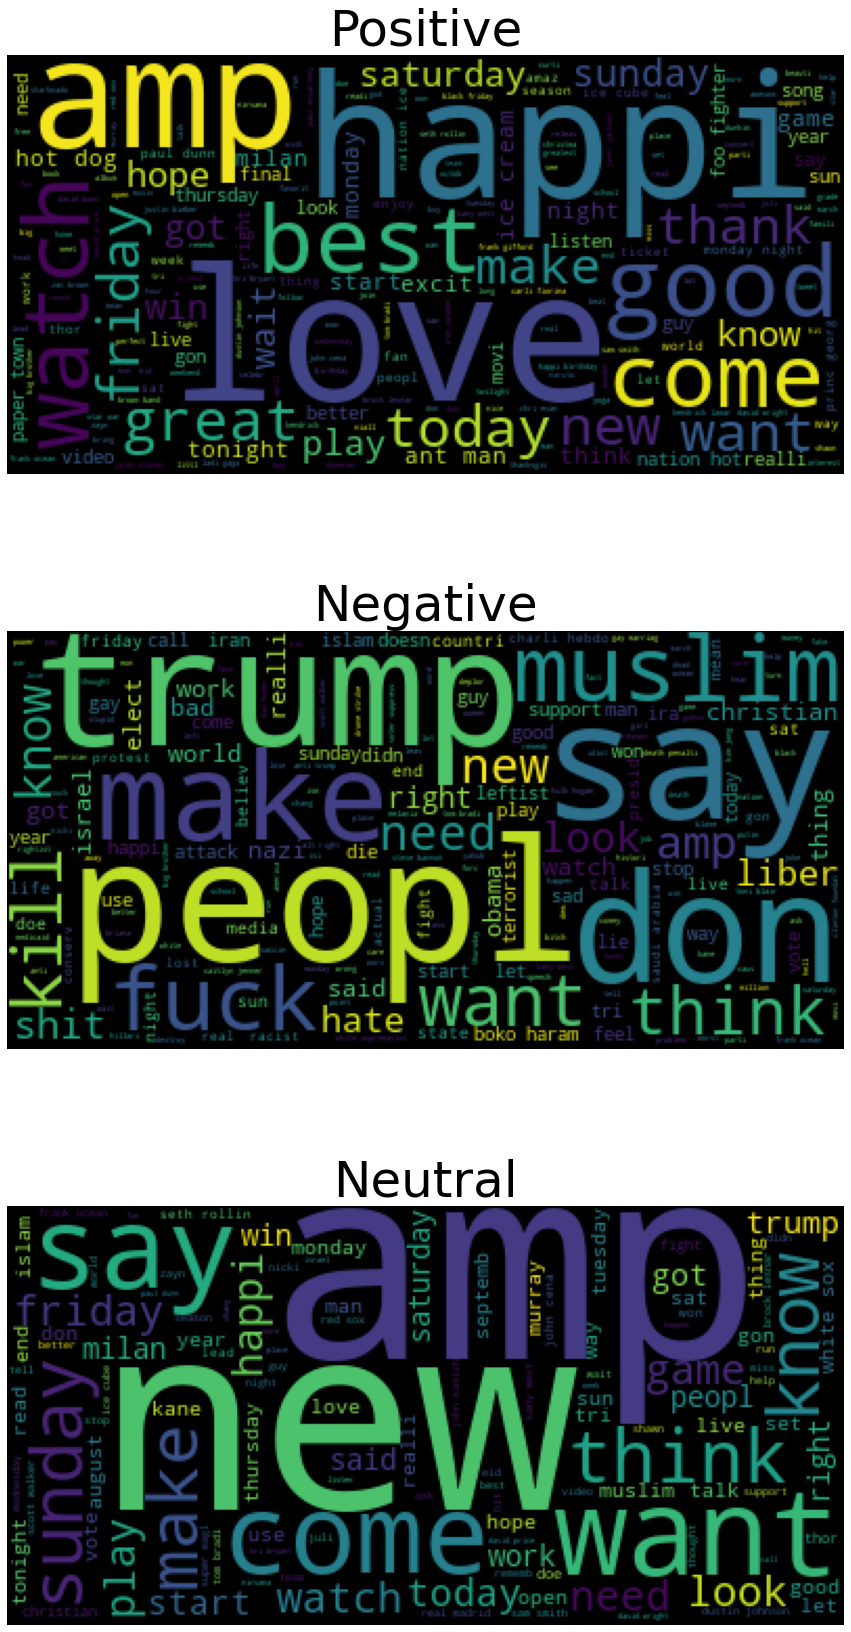

In [22]:
# Let's visualise and see if there are any recurring words(features) that are present in all three sentiments that 
# we should remove as they add little to no value

# We will visualize this on a wordcloud
wordcloud_pos = WordCloud().generate(" ".join([" ".join(word) for word in data_pos['text']]))
wordcloud_neg = WordCloud().generate(" ".join([" ".join(word) for word in data_neg['text']]))
wordcloud_neu = WordCloud().generate(" ".join([" ".join(word) for word in data_neu['text']]))


fig, (ax1,ax2,ax3) = plt.subplots(3)
fig.set_size_inches(15,30)
ax1.imshow(wordcloud_pos)
ax1.set_title('Positive', fontsize = 50)
ax1.axis("off")
ax2.imshow(wordcloud_neg)
ax2.set_title('Negative', fontsize = 50)
ax2.axis("off")
ax3.imshow(wordcloud_neu)
ax3.set_title('Neutral', fontsize = 50)
ax3.axis("off")

# Current version of wordcloud (already removed common words)

# Model Evaluation

In [31]:
# Prepare data for vectorization
X_train_data = [" ".join(words) for words in X_train_pre_trunc]
len(X_train_data)

21802

In [72]:
# TESTING on different potential models
models = [MultinomialNB(),
          DecisionTreeClassifier(max_depth=1),
          RandomForestClassifier(max_depth=100),
          LogisticRegression(max_iter = 1000)]

titles = ['MNB',
          'one-r',
          'Random Forest',
          'Logistic Regression']

# Use repeated stratified Kfold to reduce bias and variance
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=36851234)

i = 1
for train_index, test_index in rskf.split(X_train_data, Y_train):
    X_train, X_test = list(pd.DataFrame(X_train_data).iloc[train_index][0]), list(pd.DataFrame(X_train_data).iloc[test_index][0])
    y_train, y_test = list(pd.DataFrame(Y_train).iloc[train_index][0]), list(pd.DataFrame(Y_train).iloc[test_index][0])
    
    BoW_vectorizer = CountVectorizer()

    #Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
    X_train_BoW = BoW_vectorizer.fit_transform(X_train)

    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_test_BoW = BoW_vectorizer.transform(X_test)
    
    print('\n--------------------------------------- Split = ', i,'------------------------------')
    i += 1
    
    for k in [10,100,200]:
        print('\n--------------------------------------- K = ', k,'------------------------------')
        x2 = SelectKBest(chi2, k=k)
        x2.fit(X_train_BoW,y_train)
        X_train_x2 = x2.transform(X_train_BoW)
        X_test_x2 = x2.transform(X_test_BoW)


        mi = SelectKBest(score_func=mutual_info_classif, k=k)
        mi.fit(X_train_BoW,y_train)
        X_train_mi = mi.transform(X_train_BoW)
        X_test_mi = mi.transform(X_test_BoW)


        Xs = [(X_train_BoW, X_test_BoW), (X_train_x2, X_test_x2), (X_train_mi, X_test_mi)]
        X_names = ['complete', 'x2', 'mi']
        for title, model in zip(titles, models):
            print('\n=========',title, '(with k=',k,'features): ')
            for X_name, X in zip(X_names, Xs):
                X_train_t, X_test_t = X
                model.fit(X_train_t.todense(), y_train)
                y_test_predict = model.predict(X_test_t.todense())
                f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
                accuracy = accuracy_score(y_test, y_test_predict)
                print(X_name, 'f1score is:',  f1)
                print(X_name, 'accuracy is:',  accuracy)


--------------------------------------- Split =  1 ------------------------------

--------------------------------------- K =  10 ------------------------------

========= MNB (with k= 10 features): 
complete f1score is: 0.6324531681544554
complete accuracy is: 0.6393322326178683
x2 f1score is: 0.46383752645826526
x2 accuracy is: 0.593285635663181
mi f1score is: 0.46708344452522743
mi accuracy is: 0.5938359933957073

========= one-r (with k= 10 features): 
complete f1score is: 0.4570225905083291
complete accuracy is: 0.5899834892680242
x2 f1score is: 0.4570225905083291
x2 accuracy is: 0.5899834892680242
mi f1score is: 0.4570225905083291
mi accuracy is: 0.5899834892680242

========= Random Forest (with k= 10 features): 
complete f1score is: 0.5711037872342772
complete accuracy is: 0.6396991377728857
x2 f1score is: 0.5312861960254761
x2 accuracy is: 0.6152999449642268
mi f1score is: 0.5373115711751087
mi accuracy is: 0.616400660429279

========= Logistic Regression (with k= 10 features


========= MNB (with k= 100 features): 
complete f1score is: 0.6406259682987435
complete accuracy is: 0.6477064220183486
x2 f1score is: 0.6033151398302083
x2 accuracy is: 0.6475229357798166
mi f1score is: 0.6045671681535355
mi accuracy is: 0.6458715596330276

========= one-r (with k= 100 features): 
complete f1score is: 0.45372277095955765
complete accuracy is: 0.5877064220183487
x2 f1score is: 0.45372277095955765
x2 accuracy is: 0.5877064220183487
mi f1score is: 0.45372277095955765
mi accuracy is: 0.5877064220183487

========= Random Forest (with k= 100 features): 
complete f1score is: 0.5700544508639658
complete accuracy is: 0.6377981651376147
x2 f1score is: 0.6091686631426133
x2 accuracy is: 0.6398165137614679
mi f1score is: 0.6076627449575438
mi accuracy is: 0.6427522935779817

========= Logistic Regression (with k= 100 features): 
complete f1score is: 0.635975199198983
complete accuracy is: 0.6478899082568808
x2 f1score is: 0.6169221467356607
x2 accuracy is: 0.6555963302752293
mi 

In [27]:
# Now we find the best parameters for the models by testing out different parameters
i = 1
k = 200
# Use repeated stratified Kfold to reduce bias and variance
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=36851234)
for train_index, test_index in rskf.split(X_train_data, Y_train):
    X_train, X_test = list(pd.DataFrame(X_train_data).iloc[train_index][0]), list(pd.DataFrame(X_train_data).iloc[test_index][0])
    y_train, y_test = list(pd.DataFrame(Y_train).iloc[train_index][0]), list(pd.DataFrame(Y_train).iloc[test_index][0])
    
    BoW_vectorizer = CountVectorizer()
    #Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
    X_train_BoW = BoW_vectorizer.fit_transform(X_train)

    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_test_BoW = BoW_vectorizer.transform(X_test)
    
    print('\n--------------------------------------- Split = ', i,'------------------------------')
    i += 1

    x2 = SelectKBest(chi2, k=k)
    x2.fit(X_train_BoW,y_train)
    X_train_x2 = x2.transform(X_train_BoW)
    X_test_x2 = x2.transform(X_test_BoW)
    
    # Testing another value for MNB alpha = 0
    MNB_model = MultinomialNB(alpha = 0)
    MNB_model.fit(X_train_x2.todense(), y_train)
    y_test_predict = MNB_model.predict(X_test_x2.todense())
    f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
    accuracy = accuracy_score(y_test, y_test_predict)
    print('MNB where alpha is 0, the f1 is:',  f1)
    print('MNB where alpha is 0, the accuracy is:',  accuracy)
    
    
    # Testing all params for Random Forest (We use gini as it is generally a better criterion for selecting best features)
    RF_model1 = RandomForestClassifier(max_depth = 10)
    RF_model1.fit(X_train_x2.todense(), y_train)
    y_test_predict = RF_model1.predict(X_test_x2.todense())
    f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
    accuracy = accuracy_score(y_test, y_test_predict)
    print('\nRandom Forest where max_depths is 10, the f1 is:',  f1)
    print('Random FOrest where max_depths is 10, the accuracy is:',  accuracy)

    
    RF_model2 = RandomForestClassifier(max_depth = 200)
    RF_model2.fit(X_train_x2.todense(), y_train)
    y_test_predict = RF_model2.predict(X_test_x2.todense())
    f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
    accuracy = accuracy_score(y_test, y_test_predict)
    print('\nRandom Forest where max_depths is 200, the f1 is:',  f1)
    print('Random Forest where max_depths is 200, the accuracy is:',  accuracy)
    
    # Testing all params for Logistic Regression
    LR_model = LogisticRegression(max_iter = 5000)
    LR_model.fit(X_train_x2.todense(), y_train)
    y_test_predict = LR_model.predict(X_test_x2.todense())
    f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
    accuracy = accuracy_score(y_test, y_test_predict)
    print('\nLogistic Regression where max_iter is 5000, the f1 is:',  f1)
    print('Logistic Regression where max_iter is 5000, the accuracy is:',  accuracy)

    # Testing all params for Logistic Regression
    LR_model2 = LogisticRegression(max_iter = 10000)
    LR_model2.fit(X_train_x2.todense(), y_train)
    y_test_predict = LR_model2.predict(X_test_x2.todense())
    f1 =  f1_score(y_test, y_test_predict, average = 'weighted')
    accuracy = accuracy_score(y_test, y_test_predict)
    print('\nLogistic Regression where max_iter is 10000, the f1 is:',  f1)
    print('Logistic Regression where max_iter is 10000, the accuracy is:',  accuracy)
    
    
    


--------------------------------------- Split =  1 ------------------------------


/Users/jamespark/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


MNB where alpha is 0, the f1 is: 0.6251575276556213
MNB where alpha is 0, the accuracy is: 0.6486883140708127

Random Forest where max_depths is 10, the f1 is: 0.4928732051386753
Random FOrest where max_depths is 10, the accuracy is: 0.606127316088791

Random Forestwhere max_depths is 200, the f1 is: 0.6094598444340193
Random Forest where max_depths is 200, the accuracy is: 0.6373142542652724

Logistic Regression where max_iter is 5000, the f1 is: 0.6313513525302038
Logistic Regression where max_iter is 5000, the accuracy is: 0.6609796367638965

Logistic Regression where max_iter is 10000, the f1 is: 0.6313513525302038
Logistic Regression where max_iter is 10000, the accuracy is: 0.6609796367638965

--------------------------------------- Split =  2 ------------------------------
MNB where alpha is 0, the f1 is: 0.6291292726806732
MNB where alpha is 0, the accuracy is: 0.6508897450009172


/Users/jamespark/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '



Random Forest where max_depths is 10, the f1 is: 0.5082011864762377
Random FOrest where max_depths is 10, the accuracy is: 0.6143826820766832

Random Forestwhere max_depths is 200, the f1 is: 0.6216966219430188
Random Forest where max_depths is 200, the accuracy is: 0.6477710511832692

Logistic Regression where max_iter is 5000, the f1 is: 0.629054325613763
Logistic Regression where max_iter is 5000, the accuracy is: 0.6580443955237572

Logistic Regression where max_iter is 10000, the f1 is: 0.629054325613763
Logistic Regression where max_iter is 10000, the accuracy is: 0.6580443955237572

--------------------------------------- Split =  3 ------------------------------
MNB where alpha is 0, the f1 is: 0.6373558878974488
MNB where alpha is 0, the accuracy is: 0.6605504587155964


/Users/jamespark/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '



Random Forest where max_depths is 10, the f1 is: 0.4951420582471039
Random FOrest where max_depths is 10, the accuracy is: 0.6064220183486239

Random Forestwhere max_depths is 200, the f1 is: 0.6184265821550796
Random Forest where max_depths is 200, the accuracy is: 0.6456880733944954

Logistic Regression where max_iter is 5000, the f1 is: 0.6300467897310867
Logistic Regression where max_iter is 5000, the accuracy is: 0.6625688073394496

Logistic Regression where max_iter is 10000, the f1 is: 0.6300467897310867
Logistic Regression where max_iter is 10000, the accuracy is: 0.6625688073394496

--------------------------------------- Split =  4 ------------------------------
MNB where alpha is 0, the f1 is: 0.6298587559447947
MNB where alpha is 0, the accuracy is: 0.6491743119266055


/Users/jamespark/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '



Random Forest where max_depths is 10, the f1 is: 0.4988995095197779
Random FOrest where max_depths is 10, the accuracy is: 0.6091743119266055

Random Forestwhere max_depths is 200, the f1 is: 0.6135758148570121
Random Forest where max_depths is 200, the accuracy is: 0.6398165137614679

Logistic Regression where max_iter is 5000, the f1 is: 0.6325051889497724
Logistic Regression where max_iter is 5000, the accuracy is: 0.6625688073394496

Logistic Regression where max_iter is 10000, the f1 is: 0.6325051889497724
Logistic Regression where max_iter is 10000, the accuracy is: 0.6625688073394496


In [73]:

np.random.seed(1)

# Make stacking class
class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        f1 = f1_score(y, yhat, average = 'weighted')
        accuracy = accuracy_score(y, yhat)
        return f1, accuracy


classifiers = [MultinomialNB(alpha = 0),
               RandomForestClassifier(max_depth=200),
               LogisticRegression(max_iter = 5000)]

titles = ['MNB',
          'Random Forest',
          'Logistic Regression']


# Test many hyperparameters for Logistic Regression and Decision Tree as meta classifiers
meta_classifier_lr = LogisticRegression(max_iter = 1000)
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_lr2 = LogisticRegression(max_iter = 5000)
stacker_lr2 = StackingClassifier(classifiers, meta_classifier_lr2)

meta_classifier_lr3 = LogisticRegression(max_iter = 10000)
stacker_lr3 = StackingClassifier(classifiers, meta_classifier_lr3)

meta_classifier_dt = DecisionTreeClassifier(max_depth = 10)
stacker_dt = StackingClassifier(classifiers, meta_classifier_dt)

meta_classifier_dt2 = DecisionTreeClassifier(max_depth = 100)
stacker_dt2 = StackingClassifier(classifiers, meta_classifier_dt2)

meta_classifier_dt3 = DecisionTreeClassifier(max_depth = 200)
stacker_dt3 = StackingClassifier(classifiers, meta_classifier_dt3)

In [74]:
# Now we find the best parameters and metaclassifier for stacking
i = 1
k = 200
# Use repeated stratified Kfold to reduce bias and variance
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=36851234)
for train_index, test_index in rskf.split(X_train_data, Y_train):
    X_train, X_test = list(pd.DataFrame(X_train_data).iloc[train_index][0]), list(pd.DataFrame(X_train_data).iloc[test_index][0])
    y_train, y_test = list(pd.DataFrame(Y_train).iloc[train_index][0]), list(pd.DataFrame(Y_train).iloc[test_index][0])
    
    BoW_vectorizer = CountVectorizer()
    #Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
    X_train_BoW = BoW_vectorizer.fit_transform(X_train)

    #Use the feature set (vocabulary) from Train to vectorise the Test dataset 
    X_test_BoW = BoW_vectorizer.transform(X_test)
    
    print('\n--------------------------------------- Split = ', i,'------------------------------')
    i += 1
    
    x2 = SelectKBest(chi2, k=k)
    x2.fit(X_train_BoW,y_train)
    X_train_x2 = x2.transform(X_train_BoW)
    X_test_x2 = x2.transform(X_test_BoW)
    
    stacker_lr.fit(X_train_x2, y_train)
    f1_lr, accuracy_lr = stacker_lr.score(X_test_x2, y_test)
    
    stacker_lr2.fit(X_train_x2, y_train)
    f1_lr2, accuracy_lr2 = stacker_lr2.score(X_test_x2, y_test)
    
    stacker_lr3.fit(X_train_x2, y_train)
    f1_lr3, accuracy_lr3 = stacker_lr3.score(X_test_x2, y_test)
    
    print('\nStacker f1 (Logistic Regression):')
    print('max_iter = 1000: ', f1_lr)
    print('max_iter = 5000: ', f1_lr2)
    print('max_iter = 10000: ', f1_lr3)
    print('\nStacker accuracy (Logistic Regression):')
    print('max_iter = 1000: ', accuracy_lr)
    print('max_iter = 5000: ', accuracy_lr2)
    print('max_iter = 10000: ', accuracy_lr3)

    stacker_dt.fit(X_train_x2, y_train)
    f1_dt, accuracy_dt = stacker_dt.score(X_test_x2, y_test)
    
    stacker_dt2.fit(X_train_x2, y_train)
    f1_dt2, accuracy_dt2 = stacker_dt2.score(X_test_x2, y_test)
    
    stacker_dt3.fit(X_train_x2, y_train)
    f1_dt3, accuracy_dt3 = stacker_dt3.score(X_test_x2, y_test)
    print('\nStacker f1 (Decision Tree):')
    print('max_depth = 10: ', f1_dt)
    print('max_depth = 100: ', f1_dt2)
    print('max_depth = 200: ', f1_dt3)
    
    print('\nStacker accuracy (Decision Tree):')
    print('max_depth = 10: ', accuracy_dt)
    print('max_depth = 100: ', accuracy_dt2)
    print('max_depth = 200: ', accuracy_dt3)
    


--------------------------------------- Split =  1 ------------------------------

Stacker f1 (Logistic Regression):
max_iter = 1000:  0.6049752426261287
max_iter = 5000:  0.6030052486356503
max_iter = 10000:  0.6021504321835242

Stacker accuracy (Logistic Regression):
max_iter = 1000:  0.625389836727206
max_iter = 5000:  0.6237387635296275
max_iter = 10000:  0.6233718583746102

Stacker f1 (Decision Tree):
max_depth = 10:  0.6100300862109248
max_depth = 100:  0.6014853681780886
max_depth = 200:  0.6040072740220832

Stacker accuracy (Decision Tree):
max_depth = 10:  0.6334617501375894
max_depth = 100:  0.6277747202348193
max_depth = 200:  0.6296092460099064

--------------------------------------- Split =  2 ------------------------------

Stacker f1 (Logistic Regression):
max_iter = 1000:  0.6131109763484707
max_iter = 5000:  0.6106611545621444
max_iter = 10000:  0.613423743251743

Stacker accuracy (Logistic Regression):
max_iter = 1000:  0.6340121078701155
max_iter = 5000:  0.6314437

In [33]:
# Create function for preprocessing for testing
def preprocessing(data):
    
    # (1) Lowercase
    data_1 = [sentence.lower() for sentence in data]
    
    # (2) Remove URLs
    data_2 = [re.sub(url_pattern, ' ', sentence) for sentence in data_1]
    
    # (3) Remove tags
    data_3 = [re.sub(tag_pattern, '', sentence) for sentence in data_2]

    # (4) Remove hashtags
    data_4 = [re.sub(hash_pattern, '', sentence) for sentence in data_3]

    # (5) Remove punctuations
    pattern1 = r'[^\w\s]'
    data_5 = [re.sub(pattern1, ' ', sentence) for sentence in data_4]
    
    # (6) Remove stopwords
    data_6 = []
    stopwords = list(text.ENGLISH_STOP_WORDS)
    # From visualisation from wordcloud, we add more stopwords we think are necessary
    stopwords.extend(['tomorrow', 'day', 'time'])

    for sentence in data_5:
        tokens = [w for w in sentence.split() if w not in stopwords]
        data_6.append(" ".join(tokens))
        
    # (7) 1 space inbetween words
    pattern2 = r'\s+'
    data_7 = [re.sub(pattern2, ' ', sentence) for sentence in data_6]
    
    # (8) Remove all numeric numbers
    pattern3 = r'[0-9]+'
    data_8 = [re.sub(pattern3, '', sentence) for sentence in data_7]
    
    # (9) Tokenize texts and Stemming (Porter) 
    data_9 = [nltk.word_tokenize(sentence) for sentence in data_8]
    porter = PorterStemmer()
    data_10 = [[porter.stem(word) for word in words] for words in data_9]
    
    # put the tokens together for easy split for model evaluation
    data_final = [" ".join(words) for words in data_10]
    
    return data_final



In [39]:
X_test_pre = X_test_raw.copy()

In [41]:
X_test_data = preprocessing(X_test_pre)

In [80]:
# Train selected model on the entire supervised dataset and predict the sentiments for X_test
BoW_vectorizer2 = CountVectorizer()
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer2.fit_transform(X_train_data)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer2.transform(X_test_data)
k=200
test_x2 = SelectKBest(chi2, k=k)
test_x2.fit(X_train_BoW,Y_train)
X_train_x2 = test_x2.transform(X_train_BoW)
X_test_x2 = test_x2.transform(X_test_BoW)

# Get best model
LR_final = LogisticRegression(max_iter = 1000)

# Fit the model and predict
LR_final.fit(X_train_x2, Y_train)
y_predicted = LR_final.predict(X_test_x2)

# Export predictions to csv file to submit to Kaggle
output = test_data['id'].to_frame()
output['sentiment'] = y_predicted

output = test_data['id'].to_frame()
output['sentiment'] = y_predicted
output.to_csv('prediction2.csv', index = False)

